In [ ]:
#@title **Enalce a Drive e importación de librerías**

import os
"""from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/proyecto')"""

import random
#from tqdm.notebook import tqdm_notebook
from IPython.display import clear_output 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix
import cv2
import glob

sns.set_theme()

# **Carga y tratamiento del dataset**

In [ ]:
#@title **Carga de dataset**

dirs = ('train', 'test', 'val')
classes = ('c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9')
labels_dict = { 
    'c0': 'safe driving',
    'c1': 'texting - right',
    'c2': 'talking on the phone - right',
    'c3': 'texting - left',
    'c4': 'talking on the phone - left',
    'c5': 'operating the radio',
    'c6': 'drinking',
    'c7': 'reaching behind',
    'c8': 'hair and makeup',
    'c9': 'talking to passenger'
}

images = { 'train': [], 'test': [], 'val': [] }
labels = { 'train': [], 'test': [], 'val': [] }

test_paths = []

total_images = 0

t = time.time()

for directory in dirs:
  for label in classes:
    total_images += len(os.listdir(os.path.join('dataset', directory, label)))

loaded_images = 0

for directory in tqdm_notebook(dirs, desc='Carga del dataset: '):
  for label in tqdm_notebook(classes, desc='Carga del directorio (%s): ' %(directory)):
    names = os.listdir(os.path.join('dataset', directory, label))
    
    for name in names:
      path = os.path.join('dataset', directory, label, name)      

      try:
        image = keras.preprocessing.image.load_img(
            path,
            target_size=(160, 213)
        )

        if directory == 'test':
          test_paths.append(path)

        images[directory].append(np.array(image))
        labels[directory].append(label)
        
      except OSError:
        print('Ha ocurrido un error al carga la imágen : %s' % path)
      
      loaded_images += 1

print('Tiempo de carga: %.2fs' %(time.time()-t))        
        
total = len(images['train']) + len(images['test']) + len(images['val'])
train_per = str(round(len(images['train'])*100/total, 2))
test_per = str(round(len(images['test'])*100/total, 2))
val_per = str(round(len(images['val'])*100/total, 2))

print('\nImágenes cargadas')
print('Total: ', total_images)
print('Train: %d, %s%%' % (len(images['train']), train_per))
print('Test: %d, %s%%' % (len(images['test']), test_per))
print('Validation: %d, %s%%' % (len(images['val']), val_per))

Carga del dataset:   0%|          | 0/3 [00:00<?, ?it/s]

Carga del directorio (train):   0%|          | 0/10 [00:00<?, ?it/s]

Carga del directorio (test):   0%|          | 0/10 [00:00<?, ?it/s]

Carga del directorio (val):   0%|          | 0/10 [00:00<?, ?it/s]

Tiempo de carga: 99.11s

Imágenes cargadas
Total:  22424
Train: 17934, 79.98%
Test: 2253, 10.05%
Validation: 2237, 9.98%


El dataset está compuesto por 3 carpetas (train, test, val), en cada una de ellas hay 10 carpetas numeradas desde c0 hasta c9, una carpeta por cada clase del dataset.

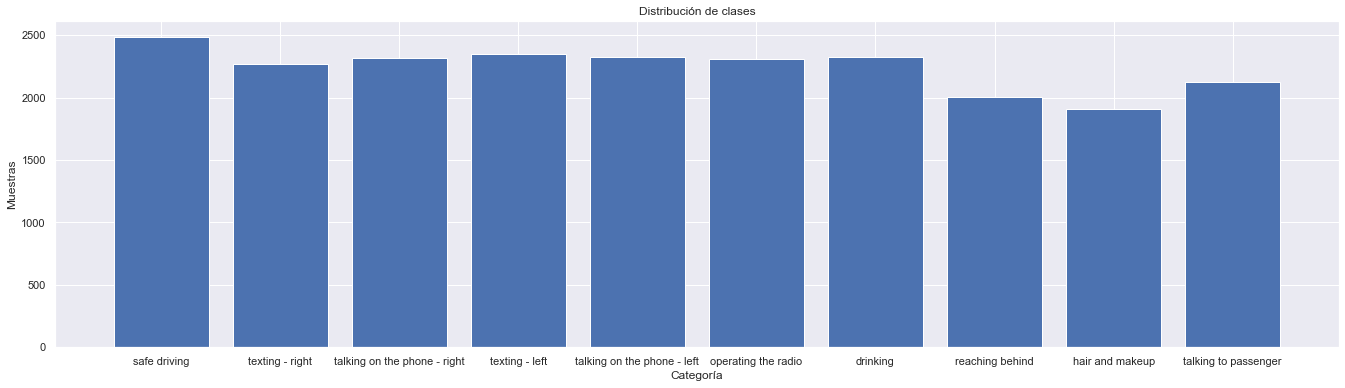

In [ ]:
#@title **Balanceo del dataset**

imgs_per_class =  { 
    'safe driving': 0,
    'texting - right': 0,
    'talking on the phone - right': 0,
    'texting - left': 0,
    'talking on the phone - left': 0,
    'operating the radio': 0,
    'drinking': 0,
    'reaching behind': 0,
    'hair and makeup': 0,
    'talking to passenger': 0
}

for directory in dirs:
    for label in classes:
        imgs_per_class[labels_dict[label]] += len(os.listdir(os.path.join('dataset', directory, label)))

sns.set_style("darkgrid")
plt.figure(figsize=(23, 6))
plt.bar(imgs_per_class.keys(), imgs_per_class.values())
plt.title('Distribución de clases')
plt.xlabel('Categoría')
plt.ylabel('Muestras')
plt.show()

Se contaron la cantidad de muestras para cada clase del dataset (tanto en train como en test y val) y se graficaron los resultados para determinar si el dataset estaba correctamente balanceado.

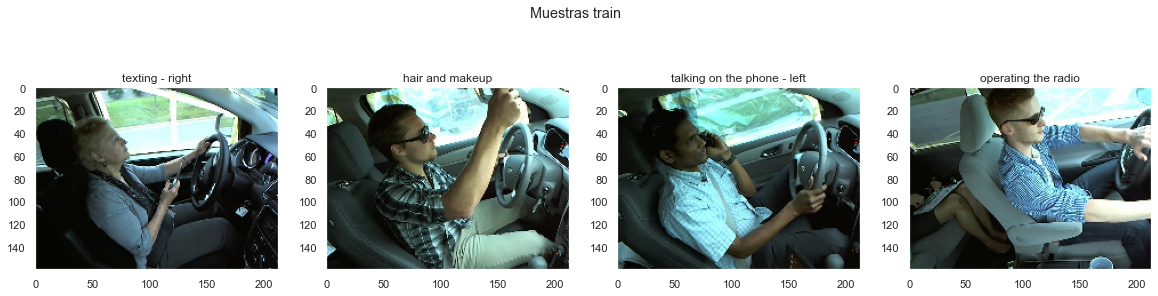

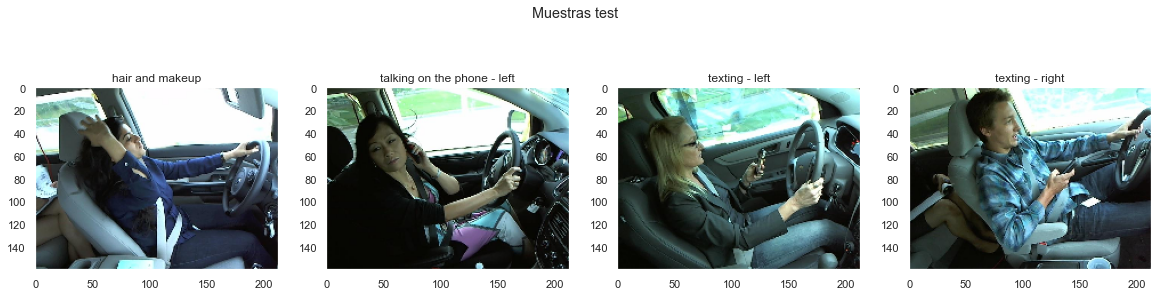

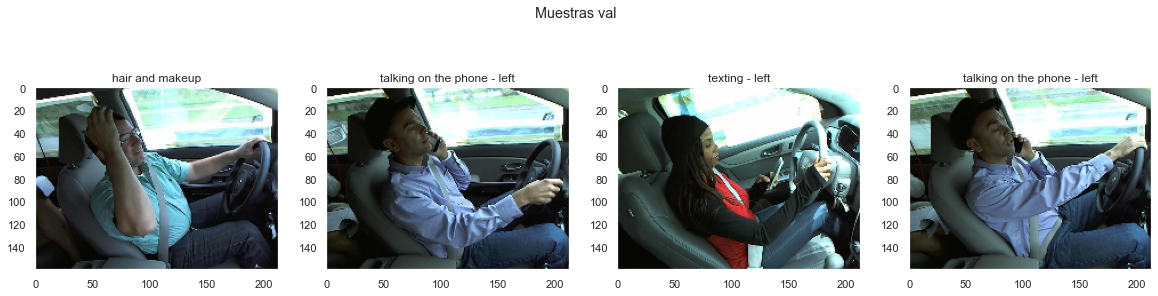

In [ ]:
#@title **Muestras del dataset**

random.seed(178)
for directory in dirs:
    plt.figure(figsize=(20, 5))
    plt.suptitle('Muestras ' + directory)
    
    for i in range(1, 5):
        rand_index = random.randint(0, len(images[directory]))

        plt.subplot(1, 4, i)
        plt.imshow(images[directory][rand_index])
        plt.title(labels_dict[labels[directory][rand_index]])
        plt.grid(False)
    plt.show()

Se graficaron algunas muestras aleatorias de cada una de las partes del dataset.

In [ ]:
#@title **División del dataset y one hot encoder**

x_train, x_test, x_val = images.values()
y_train, y_test, y_val = labels.values()

class_dict = pd.factorize(y_val)[1]

x_train = np.array(x_train)
x_test = np.array(x_test)
x_val = np.array(x_val)

y_train = np.array(keras.utils.to_categorical(pd.factorize(y_train)[0]))
y_test = np.array(keras.utils.to_categorical(pd.factorize(y_test)[0]))
y_val = np.array(keras.utils.to_categorical(pd.factorize(y_val)[0]))

Se dividió el dataset en train, test, val y se aplicó el one hot encoder a las etiquetas de las imágenes.

# **Construcción del modelo y entrenamiento**

In [ ]:
#@title **Modelo base**

input_shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3])

model = tf.keras.applications.VGG16(input_shape=input_shape, include_top=False, weights='imagenet')
model.trainable = False

model.summary()
print("capas totales: ", len(model.layers))

58900480/58889256 [==============================] - 6s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 160, 213, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 160, 213, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 160, 213, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 80, 106, 64)       0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 80, 106, 128)      73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 80, 106, 128)      147584    
______________________________________________________________

Se descarga un modelo VGG16 preentrenado con imagenet (sin top) para modificarlo y adaptarlo a nuestro problema.

In [ ]:
#@title **Nuevas capas**

prediction_layer = tf.keras.layers.Dense(y_train.shape[1], activation='softmax')
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

transition_layer1 = tf.keras.layers.Dense(256, activation='relu')
transition_layer2 = tf.keras.layers.Dense(128, activation='relu')

Se creó la capa de global average pooling para servir de puente entre la red VGG16 y las capas nuevas, adicionalmente se creó la capa software par clasificación y un par de capas densas.

In [ ]:
#@title **Nuevo modelo**

adapted_model = tf.keras.Sequential([
  model,
  global_average_layer,
  transition_layer1,
  transition_layer2,
  prediction_layer
])

adapted_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 5, 6, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense (Dense)                (None, 10)                1290      
Total params: 14,880,202
Trainable params: 165,514
Non-trainable params: 14,714,688
_________________________________________________________________


Se unió la VGG16 con las capas nuevas para formar el nuevo modelo.

In [ ]:
#@title **Parámetros del modelo**

batch_size = 64

steps_per_epoch = int(np.ceil(y_train.shape[0] / batch_size))

callbacks = [    
    keras.callbacks.ModelCheckpoint(
        'saves/epoch_{epoch:02d}-{loss:.2f}.h5',
        monitor='loss',
        mode='min',
        verbose=1,
        save_freq=steps_per_epoch * 5
    )
]

learning_rate= 0.001
opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)

epochs =  25
verbose = True

Se definieron parámetros importantes del modelo como el learning rate, número de epocas y callbacks utilizados.

In [ ]:
#@title **Entrenamiento**

adapted_model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])

history = adapted_model.fit(
    x_train, y_train,
    epochs=epochs,
    verbose=verbose,
    batch_size=batch_size,
    callbacks=callbacks,
    validation_data=(x_test, y_test)
)

Epoch 1/25
281/281 [==============================] - 71s 252ms/step - loss: 0.3587 - accuracy: 0.8870 - val_loss: 0.2068 - val_accuracy: 0.9339
Epoch 2/25
281/281 [==============================] - 126s 450ms/step - loss: 0.1106 - accuracy: 0.9670 - val_loss: 0.1248 - val_accuracy: 0.9645
Epoch 3/25
281/281 [==============================] - 144s 511ms/step - loss: 0.0664 - accuracy: 0.9791 - val_loss: 0.1310 - val_accuracy: 0.9601
Epoch 4/25
281/281 [==============================] - 152s 544ms/step - loss: 0.0442 - accuracy: 0.9861 - val_loss: 0.0761 - val_accuracy: 0.9774
Epoch 5/25
207/281 [=====================>........] - ETA: 35s - loss: 0.0486 - accuracy: 0.9839
Epoch 00005: saving model to saves\epoch_05-0.05.h5
281/281 [==============================] - 152s 539ms/step - loss: 0.0470 - accuracy: 0.9846 - val_loss: 0.0772 - val_accuracy: 0.9725
Epoch 6/25
281/281 [==============================] - 152s 540ms/step - loss: 0.0439 - accuracy: 0.9854 - val_loss: 0.1029 - val_accu

Se entrenó el modelo adaptado y gracias a un callback se guardaron de forma periódica sus pesos.

# **Evaluación y resultados del entrenamiento**

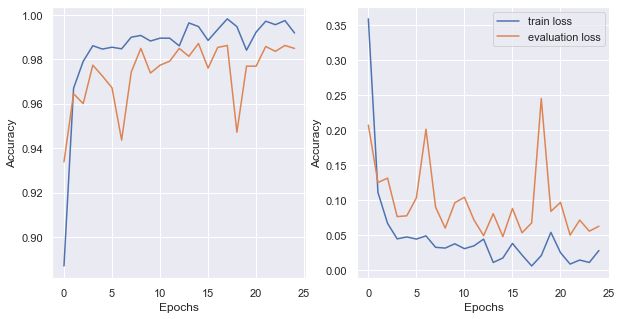

In [ ]:
#@title **Resultados del entrenamiento**

plt.figure(figsize=(10,5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='evaluation loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.legend()
plt.show()

Se graficaron la périda (imágen izquierda) y el accuracy (imágen derecha) tanto para el entrenamiento como para la parte de validación.

In [ ]:
#@title **Guardar modelo**

model_name = 'weights/weigths_all_categories.h5'

adapted_model.save(model_name)

In [ ]:
#@title **Cargar modelo**

model_name = 'weights/weigths_all_categories.h5'

adapted_model = keras.models.load_model(model_name)

In [ ]:
#@title **Evaluar modelo**

random.seed(178)

score = adapted_model.evaluate(x_test, y_test, verbose = 0) 

print('Test loss:', score[0]) 
print('Test accuracy:', score[1])
print()

predictions = adapted_model.predict(x_test)

Test loss: 0.0462941937148571
Test accuracy: 0.9875721335411072



Se evalua el modelo con la data de test para medir su pérdidda y accuracy.

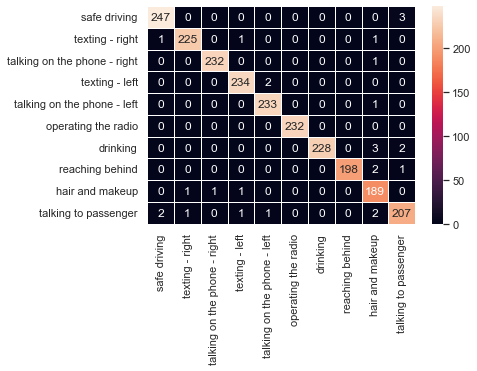

In [ ]:
#@title **Matriz de confusión**

def transform_index_label(index):
    return labels_dict[classes[index]]

heatmap_true = np.argmax(y_test, axis=1)
heatmap_pred = np.argmax(predictions, axis=1)

labels_list = [labels_dict[x] for x in classes]

heatmap_df = pd.DataFrame(confusion_matrix(heatmap_true, heatmap_pred), columns=labels_list, index=labels_list)

sns.heatmap(heatmap_df, annot=True, fmt="d", linewidths=.5)
plt.show()

Se despliega la matriz de confusión para los resultados de la evaluación con el fin de determinar gráficamente si hubo una buena o mala clasificación y si alguna clase en particular presentó un desempeño peor a las otras.

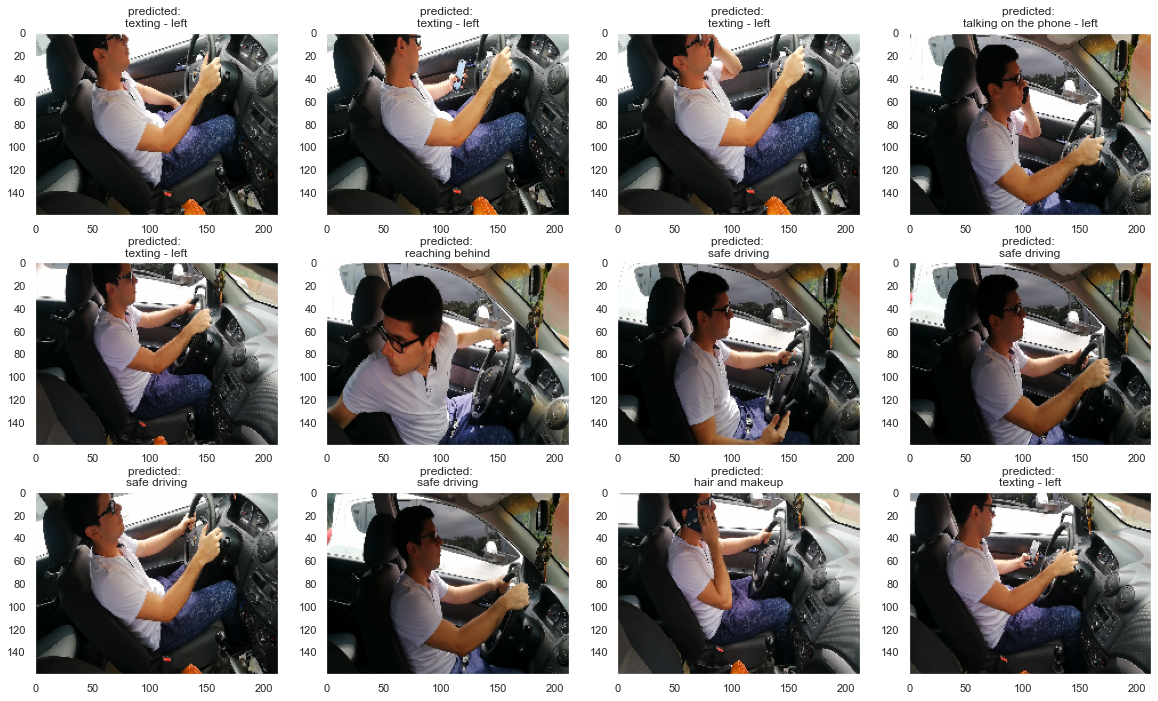

In [ ]:
#@title **Pruebas con imágenes fuera del dataset**

test_images = []
test_names = []
for path in os.listdir('pruebas'):
    test_image = np.array(keras.preprocessing.image.load_img(
      'pruebas/'+path,
      target_size=(160, 213)
    ))

    test_images.append(np.array(test_image))
    test_names.append(path)

test_images = np.array(test_images)

predictions = adapted_model.predict(test_images)

plt.figure(figsize=(20, 50))  

for i in range(len(predictions)):
    predicted = labels_dict[class_dict[np.argmax(predictions[i])]]

    plt.subplot(12, 4, i+1)
    plt.imshow(test_images[i])
    plt.title('predicted: \n' + predicted)
    plt.grid(False)

plt.show()

Se realizaron algunas pruebas con imágenes tomadas, externas al dataset original.

# **Pruebas con video**

In [ ]:
#@title **Carga de video**

cap = cv2.VideoCapture('video/prueba.mp4')

video = []
original = []

try:
    while (cap.isOpened()):
        ret, frame = cap.read()
        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        rgb = cv2.resize(rgb,(512 , 512))
        original.append(rgb)
        rgb = cv2.resize(rgb,(213 , 160))
        video.append(rgb)
except:
    cap.release()
    cv2.destroyAllWindows()
    original = np.array(original)
    video = np.array(video)/255

Se cargó un video de prueba y se separó en cada uno de sus fotogramas para evaluarlo con la CNN.

In [ ]:
#@title **Generación de predicciones**

predictions = []

for frame in tqdm_notebook(video, desc='Generando predicciones: '):
    predictions.append(adapted_model.predict(frame.reshape(-1, 160, 213, 3)))

Generando predicciones:   0%|          | 0/3557 [00:00<?, ?it/s]

Se evaluaron los fotogramas del video y se generó su respectiva predicción para cada uno de ellos.

In [ ]:
#@title **Exportación del resultado**

font = cv2.FONT_HERSHEY_DUPLEX
  
font                   = cv2.FONT_HERSHEY_SIMPLEX
bottomLeftCornerOfText = (2,original[0].shape[0]-5)
fontScale              = 0.5
fontColor              = (255,255,255)
lineType               = 2

for i, image in enumerate(original):
    text = 'Distracted'
    
    if np.argmax(predictions[i]) == 0: text = 'Safe Driving'
    
    image = cv2.putText(
        image,
        text, 
        bottomLeftCornerOfText, 
        font, 
        fontScale,
        fontColor,
        lineType
    )
    
size = (original.shape[1], original.shape[2])
duration = 60+34
fps = 25
out = cv2.VideoWriter('video/prueba_output.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, (size[1], size[0]))

for i in tqdm_notebook(range(fps * duration), desc='Exportando video: '):
    data = cv2.cvtColor(original[i],cv2.COLOR_RGB2BGR)
    out.write(data)
    
out.release()

Exportando video:   0%|          | 0/2350 [00:00<?, ?it/s]

Se tomaron los fotogramas procesados, se les agregó un label indicando si el conductor está o no distraído y se reconstruyó el video.